In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from scipy.stats import bernoulli

%matplotlib inline

In [4]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 64 * 3 * 3

lr = 0.001

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool3 = nn.AvgPool2d(3, stride=2)
        
        self.fc4 = nn.Linear(64 * 3 * 3, 10)
        

    def forward(self, x):
        activation_1 = F.relu(self.pool1(self.conv1(x)))
        activation_2 = F.relu(self.pool2(self.conv2(self.bn1(activation_1))))
        activation_3 = F.relu(self.pool3(self.conv3(self.bn2(activation_2))))
        activation_3 = activation_3.view(-1, 64 * 3 * 3)
        out = self.fc4(activation_3)
        return out, [torch.sign(activation_1.view(-1, 32 * 15 * 15)), torch.sign(activation_2.view(-1, 32 * 7 * 7)), torch.sign(activation_3)]
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): AvgPool2d (
  )
  (fc4): Linear (576 -> 10)
)


In [12]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = range(0, self.train_activations.shape[1])
        indexes1 = np.random.choice(self.train_activations.shape[0], 10000)
        indexes2 = np.random.choice(self.train_activations.shape[0], 10000)
        
        distances_layers = np.abs(self.train_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        print('Mean : %.2f, std : %.2f' % (distances_layers.mean(), distances_layers.std()) )
        plt.hist(distances_layers, bins, label='Train')
        plt.legend()
        plt.title('Histogram of distances of activation patterns')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
if cuda:
    model.cuda()
    criterion.cuda()

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics_l1 = ActivationFollower()
    metrics_l2 = ActivationFollower()
    metrics_l3 = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics_l1.train_add(activations[0].cpu().data.numpy(), target.cpu().data.numpy())
        metrics_l2.train_add(activations[1].cpu().data.numpy(), target.cpu().data.numpy())
        metrics_l3.train_add(activations[2].cpu().data.numpy(), target.cpu().data.numpy())
        if batch_idx > 1000:
            break
        
    print('Layer 1 : ----')
    metrics_l1.print_metrics()
    
    print('Layer 2 : ----')
    metrics_l2.print_metrics()
    
    print('Layer 3 : ----')
    metrics_l3.print_metrics()


In [10]:
# activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.314407
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.888169
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.120625
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.998301
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.080764
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.298387
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.081024
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.178546

Test set: Average loss: 1.1595, Accuracy: 5815/10000 (58%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.560688
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.408773
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.214661
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.771726
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.080116
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.036522
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.912761
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.378760

Test set: Average loss: 0.9359, Accuracy: 6747/10000 (67%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.577322
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.749


Test set: Average loss: 0.6834, Accuracy: 7765/10000 (78%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.461671
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.171978
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.194717
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.264714
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.304059
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.445324
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.508186
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.106045

Test set: Average loss: 0.7049, Accuracy: 7718/10000 (77%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.322883
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.401589
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.465824
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.349880
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.562021
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.238480
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.237131
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.287310

Test set: Average loss: 0.6869, Accuracy: 7792/10000 (78%)



Layer 1 : ----
Mean : 2579.01, std : 387.24


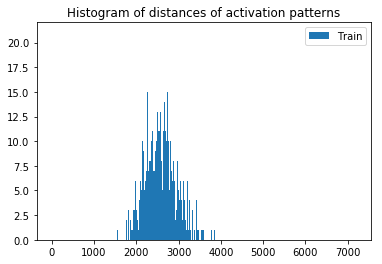

Layer 2 : ----
Mean : 644.06, std : 57.65


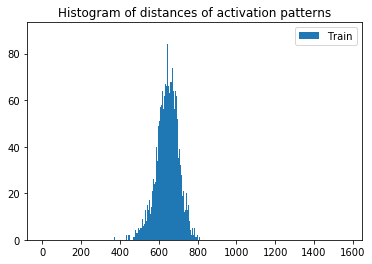

Layer 3 : ----
Mean : 270.26, std : 34.50


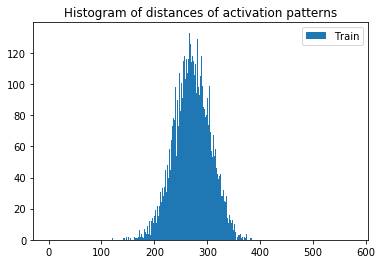

In [13]:
activation_metrics()

Layer 1 : ----
(16032, 7200)


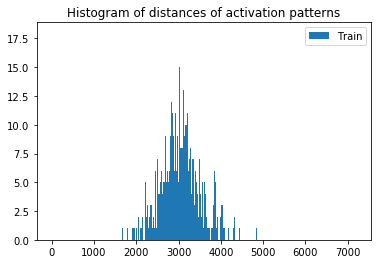

Layer 2 : ----
(16032, 1568)


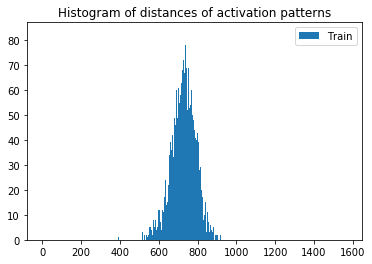

Layer 3 : ----
(16032, 576)


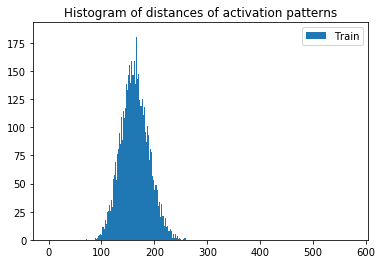

In [92]:
activation_metrics()